In [1]:
import numpy as np
import pandas as pd

# グラフ描画
from matplotlib import pylab as plt

# グラフを横長にする
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

In [2]:
import tensorflow as tf

In [3]:
df = pd.read_csv('USD_JPY_M1_20210120_20210204.csv')

In [4]:
def make_dataset(data_arr, window_size):

    data, target = [], []

    for i in range(len(data_arr)-window_size):
        data.append(data_arr[i:i + window_size])
        target.append(data_arr[i + window_size])

    re_data = np.array(data).reshape(len(data), window_size, 1)
    re_target = np.array(target).reshape(len(data), 1)

    return re_data, re_target

In [17]:
window = 40
data_length = 15000

mean_close =  df['C'].values[-data_length:].mean()
std_close =  df['C'].values[-data_length:].std()
close_adj = (df['C'].values[-data_length:] - mean_close) / std_close

x, y = make_dataset(close_adj, window)

In [18]:
val_size = 100
test_size = 100

x_train =  x[:-test_size][:-val_size]
x_val =  x[:-test_size][-val_size:]
x_test = x[-test_size:]

y_train =  y[:-test_size][:-val_size]
y_val =  y[:-test_size][-val_size:]
y_test = y[-test_size:]

In [19]:
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(500, activation='relu', input_shape=(None, 1)),
    tf.keras.layers.Dense(1)
])
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.MeanSquaredError())

In [20]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 500)               1004000   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 501       
Total params: 1,004,501
Trainable params: 1,004,501
Non-trainable params: 0
_________________________________________________________________


In [21]:
batch_size = 60
n_epoch = 150

# 学習
hist = model.fit(x_train, y_train,
                 epochs=n_epoch,
                 validation_data=(x_val, y_val),
                 verbose=1,
                 batch_size=batch_size)

Epoch 1/150
246/246 [==============================] - 22s 88ms/step - loss: 0.1229 - val_loss: 0.0016
Epoch 2/150
246/246 [==============================] - 22s 89ms/step - loss: 5.2716e-04 - val_loss: 0.0013
Epoch 3/150
246/246 [==============================] - 22s 88ms/step - loss: 5.3971e-04 - val_loss: 0.0012
Epoch 4/150
246/246 [==============================] - 22s 90ms/step - loss: 4.6271e-04 - val_loss: 0.0013
Epoch 5/150
246/246 [==============================] - 22s 90ms/step - loss: 4.4881e-04 - val_loss: 0.0011
Epoch 6/150
246/246 [==============================] - 22s 90ms/step - loss: 4.2699e-04 - val_loss: 0.0016
Epoch 7/150
246/246 [==============================] - 22s 90ms/step - loss: 3.7101e-04 - val_loss: 0.0011
Epoch 8/150
246/246 [==============================] - 22s 90ms/step - loss: 3.6687e-04 - val_loss: 0.0016
Epoch 9/150
246/246 [==============================] - 22s 90ms/step - loss: 4.0724e-04 - val_loss: 0.0011
Epoch 10/150
246/246 [===================

Epoch 75/150
246/246 [==============================] - 22s 90ms/step - loss: 1.7054e-04 - val_loss: 5.4926e-04
Epoch 76/150
246/246 [==============================] - 22s 90ms/step - loss: 1.8260e-04 - val_loss: 5.4831e-04
Epoch 77/150
246/246 [==============================] - 22s 90ms/step - loss: 2.0105e-04 - val_loss: 5.8463e-04
Epoch 78/150
246/246 [==============================] - 22s 90ms/step - loss: 1.5534e-04 - val_loss: 6.0470e-04
Epoch 79/150
246/246 [==============================] - 22s 89ms/step - loss: 1.8560e-04 - val_loss: 5.2759e-04
Epoch 80/150
246/246 [==============================] - 22s 89ms/step - loss: 1.6433e-04 - val_loss: 6.0873e-04
Epoch 81/150
246/246 [==============================] - 22s 89ms/step - loss: 1.8300e-04 - val_loss: 5.3092e-04
Epoch 82/150
246/246 [==============================] - 22s 89ms/step - loss: 1.6922e-04 - val_loss: 7.1766e-04
Epoch 83/150
246/246 [==============================] - 22s 89ms/step - loss: 1.8197e-04 - val_loss: 6.2

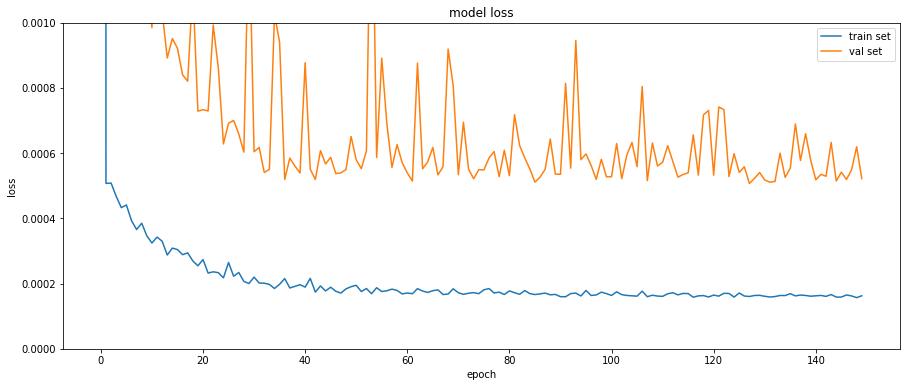

In [27]:
plt.plot(hist.history['loss'],label="train set")
plt.plot(hist.history['val_loss'],label="val set")
plt.title('model loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.ylim(0, 0.001)
plt.legend()
plt.show()

In [23]:
# y_pred = model.predict(x_test)
# y_stack = np.vstack([y_train, y_val, y_pred])
y_stack  = model.predict(x)
y_stack = std_close * y_stack + mean_close

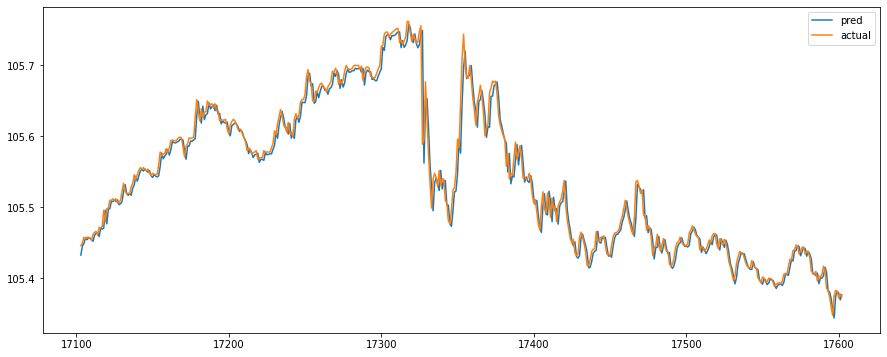

In [24]:
pd.Series(y_stack[:, 0], index=df[-data_length+window:].index)[-500:].plot(label='pred')
df[-data_length+window:]['C'][-500:].plot(label='actual')
plt.legend()
plt.show()